# 1. Load Data and perform basic operations

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
deloitte_data_filename = 'Deloitte_DrugDiscovery_dataset.csv'

In [4]:
kiba_df = pd.read_csv(deloitte_data_filename)


### drop any rows with NA's - not too many

In [5]:
kiba_df = kiba_df.dropna()

### for any cases where same UniProtID and pubchem_cid is associated with multiple kiba scores, lets take the mean

In [6]:
kiba_df = kiba_df.groupby(['UniProt_ID', 'pubchem_cid'], as_index=False).mean()

In [7]:
kiba_df.shape

(1071302, 4)

In [62]:
kiba_df.head()

,UniProt_ID,pubchem_cid,kiba_score,kiba_score_estimated
0,A0A0B4J268,7428.0,21400.0,1.0
1,A0A0B4J268,65303.0,21300.0,1.0
2,A0A0B4J268,96506.0,21400.0,1.0
3,A0A0B4J268,174326.0,21300.0,1.0
4,A0A0B4J268,225906.0,7910.0,1.0


In [9]:
unique_protein_ids = kiba_df.UniProt_ID.unique().tolist()

In [10]:
len(unique_protein_ids)

4356

In [23]:
unique_chemical_ids = kiba_df.pubchem_cid.unique().astype(int).astype(str).tolist()

In [24]:
len(unique_chemical_ids)

665492

# 2. Query useful features from pubchem 

In [26]:
import requests
from io import StringIO
import xml.etree.ElementTree as ET


First, we put together a list of potentially useful features. I dug up the pubchem API and basically looked at all available numerical features that seem useful, as well as CanonicalSMILES. I kind of forgot molecular weight, but there are several other features that convey the same thing (i.e. ExactMAss)

In [16]:

needed_props = ['CanonicalSMILES','XLogP',
       'ExactMass', 'MonoisotopicMass', 'TPSA', 'Complexity', 'Charge',
       'HBondDonorCount', 'HBondAcceptorCount', 'RotatableBondCount',
       'HeavyAtomCount', 'IsotopeAtomCount', 'AtomStereoCount',
       'DefinedAtomStereoCount', 'UndefinedAtomStereoCount', 'BondStereoCount',
       'DefinedBondStereoCount', 'UndefinedBondStereoCount',
       'CovalentUnitCount', 'PatentCount', 'PatentFamilyCount',
       'LiteratureCount', 'Volume3D', 'XStericQuadrupole3D',
       'YStericQuadrupole3D', 'ZStericQuadrupole3D', 'FeatureCount3D',
       'FeatureAcceptorCount3D', 'FeatureDonorCount3D', 'FeatureAnionCount3D',
       'FeatureCationCount3D', 'FeatureRingCount3D',
       'FeatureHydrophobeCount3D', 'ConformerModelRMSD3D',
       'EffectiveRotorCount3D', 'ConformerCount3D']

### this function returns a list of query results from pubchem db RATE_LIMIT entries at a time. I found that I needed to query chem IDS in batches, as otherwise the URL would be too long.

### even still, for all 600k+ chem IDs I need to query, this function took a few hours to run. 

In [27]:
def return_pubchem_features_listkey(props, chem_ids):
    # https://pubchem.ncbi.nlm.nih.gov/docs/pug-rest#section=Synonyms
    RATE_LIMIT = 400
    total_features = []
    for i in range(len(chem_ids)//RATE_LIMIT + 1):
        print(f'doing nums {i*RATE_LIMIT} to {(i+1)*RATE_LIMIT}')
        start_range = i*RATE_LIMIT
        end_range = min([(i+1)*RATE_LIMIT, len(chem_ids)])
        url = f'https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/{','.join(chem_ids[start_range:end_range])}/cids/XML?list_return=listkey'
        response = requests.post(url)
        print('response: ',response)
        root = ET.fromstring(response.text)
        
        
        # Define the namespace
        namespace = {"ns": "http://pubchem.ncbi.nlm.nih.gov/pug_rest"}
        
        # Find and retrieve the ListKey value
        listkey = root.find("ns:ListKey", namespaces=namespace).text
        print("ListKey:", listkey)
        property_url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/listkey/{listkey}/property/{props}/CSV"
        
        # Make a GET request to retrieve the properties
        property_response = requests.get(property_url)
        print('property response: ',property_response)
        features = pd.read_csv(StringIO(property_response.text))
        total_features.append(features)
        #time.sleep(1)
    return total_features

### for the purpose of demonstration, i will run this with just the first 999 chem ids. I will then load in a csv that I made after running the code in a different notebook for hours.

In [29]:
chem_features_queried = return_pubchem_features_listkey(','.join(needed_props), unique_chemical_ids[0:999])

doing nums 0 to 400
response:  <Response [200]>
ListKey: 4105102118911947110
property response:  <Response [200]>
doing nums 400 to 800
response:  <Response [200]>
ListKey: 1663397964997230401
property response:  <Response [200]>
doing nums 800 to 1200
response:  <Response [200]>
ListKey: 2082866392186448229
property response:  <Response [200]>


In [30]:
chem_features_df = pd.concat(chem_features_queried)

In [31]:
chem_features_df.head()

,CID,CanonicalSMILES,XLogP,ExactMass,MonoisotopicMass,TPSA,Complexity,Charge,HBondDonorCount,HBondAcceptorCount,...,FeatureCount3D,FeatureAcceptorCount3D,FeatureDonorCount3D,FeatureAnionCount3D,FeatureCationCount3D,FeatureRingCount3D,FeatureHydrophobeCount3D,ConformerModelRMSD3D,EffectiveRotorCount3D,ConformerCount3D
0,7428,COC(=O)C1=CC(=C(C(=C1)O)O)O,0.9,184.037173,184.037173,87.0,181.0,0,3,5,...,5.0,1.0,3.0,0.0,0.0,1.0,0.0,0.6,2.0,1
1,65303,C1=CC=C(C(=C1)C(=O)NNC(=O)C2=CC=CC=C2O)O,2.8,272.079707,272.079707,98.7,327.0,0,4,4,...,8.0,2.0,4.0,0.0,0.0,2.0,0.0,0.8,5.0,10
2,96506,C1=CC(=CC=C1C2=CC(=O)C3=C(C(=C(C(=C3O2)O)O)O)O)O,2.0,302.042653,302.042653,127.0,469.0,0,5,7,...,10.0,2.0,5.0,0.0,0.0,3.0,0.0,0.6,1.0,1
3,174326,CC1=C(C(=O)N(N1)C2=CC=CC=C2)N=NC3=CC=CC=C3O,3.5,294.111676,294.111676,77.3,483.0,0,2,5,...,6.0,1.0,2.0,0.0,0.0,3.0,0.0,0.6,3.0,10
4,225906,C1=CC2=C(C(=C1)[N+](=O)[O-])NC=C(C2=O)C(=O)O,1.7,234.027671,234.027671,112.0,411.0,0,2,6,...,11.0,5.0,1.0,2.0,1.0,2.0,0.0,0.6,2.0,1


### in the end, i did not end up using a version of my workflow where i attempted to extract additional features from CanonicalSMILES - it was just too slow on my laptop

In [32]:
chem_features_df = chem_features_df.drop(columns=['CanonicalSMILES'])

In [33]:
chem_features_df.shape

(999, 36)

### I will now replace this one with a ringer that I made with all unique chemical IDs

In [34]:
chem_features_df = pd.read_csv('collateral/chem_features_from_api_complete.csv')

In [35]:
chem_features_df.shape

(665492, 36)

# 3. Query protein DB and obtain additional protein features from sequence

Needed a slightly different strategy for querying proteins. I decided to get the sequence, mass, length, annotation score and feature count

In [36]:
def query_uniprot_features(uniprot_ids):
    # Join IDs into a single query string
    query = " OR ".join(uniprot_ids)
    
    # Define the UniProt API endpoint
    url = "https://rest.uniprot.org/uniprotkb/search"
    
    # Define the fields you want to retrieve
    fields = "mass,sequence,length,feature_count,annotation_score"
    
    # Parameters for the API call
    params = {
        "query": query,
        "fields": fields,
        "format": "json",
        "size": len(uniprot_ids)  # Number of records to return
    }
    
    # Make the API request
    response = requests.get(url, params=params)
    response.raise_for_status()
    # Print the response JSON to check its structure

# Print the columns in the DataFrame
    # Parse JSON response into a DataFrame
    data = response.json()["results"]
    df = pd.json_normalize(data)
    # Optional: Rename columns for easier readability
    
    return df

Once again, in order to avoid slamming the server we have to do it a little bit at a time. This function just calls the above one for 100 proteins at a time

In [37]:
def return_uniprot_features(prot_ids):
    RATE_LIMIT = 100
    total_features = []
    for i in range(len(prot_ids)//RATE_LIMIT + 1):
        print(f'doing nums {i*RATE_LIMIT} to {(i+1)*RATE_LIMIT}')
        start_range = i*RATE_LIMIT
        end_range = min([(i+1)*RATE_LIMIT, len(prot_ids)])
        features = query_uniprot_features(prot_ids[start_range:end_range])
        total_features.append(features)
    return total_features

This query pile goes faster since there are only < 5000 proteins, but i am still going to demonstrate with just a subset and replace with my pre-made collateral file

In [38]:
prot_features = return_uniprot_features(unique_protein_ids[0:250])

doing nums 0 to 100
doing nums 100 to 200
doing nums 200 to 300


In [39]:
prot_features_df = pd.concat(prot_features)

In [40]:
prot_features_df.head()

,entryType,primaryAccession,annotationScore,sequence.value,sequence.length,sequence.molWeight,sequence.crc64,sequence.md5,extraAttributes.countByFeatureType.Chain,extraAttributes.countByFeatureType.Alternative sequence,...,extraAttributes.countByFeatureType.Transit peptide,extraAttributes.countByFeatureType.DNA binding,extraAttributes.countByFeatureType.Zinc finger,extraAttributes.countByFeatureType.Cross-link,extraAttributes.countByFeatureType.Propeptide,extraAttributes.countByFeatureType.Coiled coil,extraAttributes.countByFeatureType.Repeat,extraAttributes.countByFeatureType.Intramembrane,extraAttributes.countByFeatureType.Lipidation,extraAttributes.countByFeatureType.Non-terminal residue
0,UniProtKB reviewed (Swiss-Prot),A4D1B5,5.0,MALRLVADFDLGKDVLPWLRAQRAVSEASGAGSGGADVLENDYESL...,854,97802,D7B4A3A95E2E8C3B,D71FF187867BD6060EF7D63B157928B3,2,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,UniProtKB reviewed (Swiss-Prot),O00214,5.0,MMLSLNNLQNIIYNPVIPFVGTIPDQLDPGTLIVIRGHVPSDADRF...,317,35808,AA13116AC5C0D69A,D7706ACA6BA794A38254243876D9E868,1,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,UniProtKB reviewed (Swiss-Prot),O00329,5.0,MPPGVDCPMEFWTKEENQSVVVDFLLPTGVYLNFPVSRNANLSTIK...,1044,119479,A38B5D1A1081A3D0,69F91A46A5356658458E344EA4A78BCA,1,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,UniProtKB reviewed (Swiss-Prot),O00337,5.0,MENDPSRRRESISLTPVAKGLENMGADFLESLEEGQLPRSDLSPAE...,649,71584,42E952443B46B102,E96CA9D6C8D69E344D43C4BFEBCC336B,1,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,UniProtKB reviewed (Swiss-Prot),O00400,5.0,MSPTISHKDSSRQRRPGNFSHSLDMKSGPLPPGGWDDSHLDSAGRE...,549,60909,ABDE59DEDEBAA9A5,464C8B39B7D236C9C0EB7410CBA3A93F,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


since some of the extraAttributes features may not be exposed for a given set of proteins, i need to make sure that all the ones I am expecting from the full dataset are there. In this case, i only see 41 columns but I know there should be 45 for the full version

In [41]:
expected_protein_query_columns = ['primaryAccession', 'annotationScore', 'sequence.value',
       'sequence.length', 'sequence.molWeight',
       'extraAttributes.countByFeatureType.Chain',
       'extraAttributes.countByFeatureType.Topological domain',
       'extraAttributes.countByFeatureType.Transmembrane',
       'extraAttributes.countByFeatureType.Region',
       'extraAttributes.countByFeatureType.Binding site',
       'extraAttributes.countByFeatureType.Glycosylation',
       'extraAttributes.countByFeatureType.Disulfide bond',
       'extraAttributes.countByFeatureType.Natural variant',
       'extraAttributes.countByFeatureType.Helix',
       'extraAttributes.countByFeatureType.Beta strand',
       'extraAttributes.countByFeatureType.Turn',
       'extraAttributes.countByFeatureType.Lipidation',
       'extraAttributes.countByFeatureType.Initiator methionine',
       'extraAttributes.countByFeatureType.Domain',
       'extraAttributes.countByFeatureType.Active site',
       'extraAttributes.countByFeatureType.Modified residue',
       'extraAttributes.countByFeatureType.Alternative sequence',
       'extraAttributes.countByFeatureType.Mutagenesis',
       'extraAttributes.countByFeatureType.Signal',
       'extraAttributes.countByFeatureType.Motif',
       'extraAttributes.countByFeatureType.Compositional bias',
       'extraAttributes.countByFeatureType.Sequence conflict',
       'extraAttributes.countByFeatureType.Site',
       'extraAttributes.countByFeatureType.Zinc finger',
       'extraAttributes.countByFeatureType.Coiled coil',
       'extraAttributes.countByFeatureType.Cross-link',
       'extraAttributes.countByFeatureType.DNA binding',
       'extraAttributes.countByFeatureType.Repeat',
       'extraAttributes.countByFeatureType.Propeptide',
       'extraAttributes.countByFeatureType.Transit peptide',
       'extraAttributes.countByFeatureType.Peptide',
       'extraAttributes.countByFeatureType.Intramembrane',
       'extraAttributes.countByFeatureType.Non-terminal residue',
       'extraAttributes.countByFeatureType.Non-standard residue',
       'extraAttributes.countByFeatureType.Non-adjacent residues',
       'extraAttributes.countByFeatureType.Sequence uncertainty']

In [42]:
for colname in expected_protein_query_columns:
    if colname not in prot_features_df.columns:
        prot_features_df[colname] = 0

In [43]:
prot_features_df.shape

(250, 45)

however we don't actually need some of the string features

In [45]:
prot_features_df = prot_features_df.drop(columns=['entryType',  'sequence.crc64', 'sequence.md5', 'extraAttributes.uniParcId'])

In [46]:
prot_features_df.shape

(250, 41)

## 3.1 use biopython to extract additional sequence features 
I was originally hoping I would have the time and resources to do something fancy with the sequence, such as protBERT embeddings or at least some kmer-based features. However, I must admit I have a humble 2019 macbook and it was just too slow to extract the features, and I don't quite have the capacity to train a powerful model from those features anyway.

Anyway, I revert to BioPython ProteinAnalaysis package

In [44]:
from Bio.SeqUtils.ProtParam import ProteinAnalysis


In [47]:
def extract_sequence_features(sequence):
    stripped_sequence = sequence.replace('U','').replace('X', '').replace('B', 'N').replace('Z', 'Q') 
    # this is not ideal, but a few weird protein sequences break the biopython function. 
    # https://www.genome.jp/kegg/tables/br08081.html - my resource to tell me how to best replace the off-kilter amino acids
    analysis = ProteinAnalysis(stripped_sequence)
    
    # Physicochemical descriptors
    
    aa_composition = analysis.get_amino_acids_percent()
    molecular_weight = analysis.molecular_weight()
    pI = analysis.isoelectric_point()
    aromaticity = analysis.aromaticity()
    instability_index = analysis.instability_index()
    gravy = analysis.gravy()
    sec_struct_fraction = analysis.secondary_structure_fraction()
    return_dict = aa_composition
    return_dict['protein_seq_molecular_weight'] = molecular_weight
    return_dict['protein_seq_pI'] = pI
    return_dict['protein_seq_aromaticity'] = aromaticity
    return_dict['protein_seq_instability_index'] = instability_index
    return_dict['protein_seq_gravy'] = gravy
    return_dict['protein_seq_struct_fraction_helix'] = sec_struct_fraction[0]
    return_dict['protein_seq_struct_fraction_turn'] = sec_struct_fraction[1]
    return_dict['protein_seq_struct_fraction_sheet'] = sec_struct_fraction[2]
    return return_dict

In [48]:
sequence_features = prot_features_df['sequence.value'].apply(lambda x: extract_sequence_features(x))

In [49]:
protein_seq_features_df = pd.DataFrame(sequence_features.values.tolist())

In [50]:
protein_seq_features_df.shape

(250, 28)

In [51]:
protein_seq_features_df.head()

,A,C,D,E,F,G,H,I,K,L,...,W,Y,protein_seq_molecular_weight,protein_seq_pI,protein_seq_aromaticity,protein_seq_instability_index,protein_seq_gravy,protein_seq_struct_fraction_helix,protein_seq_struct_fraction_turn,protein_seq_struct_fraction_sheet
0,0.046838,0.025761,0.045667,0.062061,0.042155,0.044496,0.046838,0.058548,0.055035,0.139344,...,0.015222,0.038642,97800.3613,6.376335,0.096019,42.289251,-0.117096,0.359485,0.220141,0.268150
1,0.044164,0.009464,0.047319,0.063091,0.059937,0.066246,0.028391,0.078864,0.059937,0.088328,...,0.009464,0.022082,35807.6716,8.334747,0.091483,30.146688,-0.217350,0.334385,0.261830,0.217666
2,0.065134,0.028736,0.044061,0.077586,0.045019,0.046935,0.029693,0.035441,0.064176,0.136015,...,0.017241,0.027778,119477.8001,6.788588,0.090038,48.604119,-0.254981,0.320881,0.199234,0.305556
3,0.103236,0.030817,0.027735,0.052388,0.064715,0.066256,0.012327,0.053929,0.029276,0.143297,...,0.021572,0.020031,71583.2292,7.767412,0.106317,43.757334,0.499230,0.382126,0.204931,0.323575
4,0.067395,0.016393,0.045537,0.034608,0.061931,0.076503,0.010929,0.049180,0.051002,0.143898,...,0.023679,0.040073,60908.2320,6.984341,0.125683,31.024791,0.302368,0.397086,0.233151,0.264117


Now to combine sequence features with other queried features:

In [52]:
prot_features_combined_df = pd.concat([prot_features_df.reset_index(drop=True), protein_seq_features_df], axis=1)

In [54]:
prot_features_combined_df.loc[0]

primaryAccession                                                                A4D1B5
annotationScore                                                                    5.0
sequence.value                       MALRLVADFDLGKDVLPWLRAQRAVSEASGAGSGGADVLENDYESL...
sequence.length                                                                    854
sequence.molWeight                                                               97802
                                                           ...                        
protein_seq_instability_index                                                42.289251
protein_seq_gravy                                                            -0.117096
protein_seq_struct_fraction_helix                                             0.359485
protein_seq_struct_fraction_turn                                              0.220141
protein_seq_struct_fraction_sheet                                              0.26815
Name: 0, Length: 69, dtype: object

We can drop sequence now, and rename primaryAccession back to UniProt_ID

In [56]:
prot_features_combined_df = prot_features_combined_df.drop(columns=['sequence.value']).rename(columns={'primaryAccession': 'UniProt_ID'})

In [57]:
prot_features_combined_df.head()

,UniProt_ID,annotationScore,sequence.length,sequence.molWeight,extraAttributes.countByFeatureType.Chain,extraAttributes.countByFeatureType.Alternative sequence,extraAttributes.countByFeatureType.Natural variant,extraAttributes.countByFeatureType.Domain,extraAttributes.countByFeatureType.Binding site,extraAttributes.countByFeatureType.Site,...,W,Y,protein_seq_molecular_weight,protein_seq_pI,protein_seq_aromaticity,protein_seq_instability_index,protein_seq_gravy,protein_seq_struct_fraction_helix,protein_seq_struct_fraction_turn,protein_seq_struct_fraction_sheet
0,A4D1B5,5.0,854,97802,2,4.0,4.0,NaN,NaN,NaN,...,0.015222,0.038642,97800.3613,6.376335,0.096019,42.289251,-0.117096,0.359485,0.220141,0.268150
1,O00214,5.0,317,35808,1,1.0,4.0,2.0,4.0,1.0,...,0.009464,0.022082,35807.6716,8.334747,0.091483,30.146688,-0.217350,0.334385,0.261830,0.217666
2,O00329,5.0,1044,119479,1,2.0,2.0,5.0,NaN,NaN,...,0.017241,0.027778,119477.8001,6.788588,0.090038,48.604119,-0.254981,0.320881,0.199234,0.305556
3,O00337,5.0,649,71584,1,2.0,10.0,NaN,NaN,NaN,...,0.021572,0.020031,71583.2292,7.767412,0.106317,43.757334,0.499230,0.382126,0.204931,0.323575
4,O00400,5.0,549,60909,1,NaN,4.0,NaN,NaN,NaN,...,0.023679,0.040073,60908.2320,6.984341,0.125683,31.024791,0.302368,0.397086,0.233151,0.264117


Time to replace it with the ringer

In [58]:
prot_features_combined_df = pd.read_csv('collateral/110824_protein_features.csv')

In [60]:
prot_features_combined_df.head()

,UniProt_ID,annotationScore,sequence.length,sequence.molWeight,extraAttributes.countByFeatureType.Chain,extraAttributes.countByFeatureType.Topological domain,extraAttributes.countByFeatureType.Transmembrane,extraAttributes.countByFeatureType.Region,extraAttributes.countByFeatureType.Binding site,extraAttributes.countByFeatureType.Glycosylation,...,W,Y,protein_seq_molecular_weight,protein_seq_pI,protein_seq_aromaticity,protein_seq_instability_index,protein_seq_gravy,protein_seq_struct_fraction_helix,protein_seq_struct_fraction_turn,protein_seq_struct_fraction_sheet
0,P29274,5.0,412,44707,1.0,8.0,7.0,1.0,4.0,1.0,...,0.016990,0.026699,44706.8798,8.335069,0.092233,39.562864,0.460680,0.368932,0.247573,0.279126
1,P29275,5.0,332,36333,1.0,8.0,7.0,0.0,4.0,2.0,...,0.015060,0.036145,36332.6495,8.623565,0.108434,30.821416,0.711145,0.406627,0.195783,0.289157
2,P12931,5.0,536,59835,1.0,0.0,0.0,1.0,2.0,0.0,...,0.016791,0.042910,59834.0535,7.103817,0.098881,43.764571,-0.472575,0.276119,0.242537,0.272388
3,P04626,5.0,1255,137910,1.0,2.0,1.0,4.0,2.0,7.0,...,0.011952,0.027888,137909.0680,5.584965,0.067729,56.134430,-0.247490,0.278884,0.258167,0.255777
4,P43405,5.0,635,72066,1.0,0.0,0.0,2.0,2.0,0.0,...,0.017323,0.053543,72065.3676,8.431965,0.100787,40.852126,-0.537480,0.292913,0.237795,0.270866


In [61]:
prot_features_combined_df.shape

(4480, 68)

# 4. Mix things together and final preparation before we do modeling

In [63]:
combined_kiba_prot_df = kiba_df.merge(prot_features_combined_df, how='inner', on='UniProt_ID')

In [64]:
combined_kiba_prot_df.shape

(1071302, 71)

In [69]:
combined_kiba_prot_df['pubchem_cid'] = combined_kiba_prot_df['pubchem_cid'].astype(int)

In [68]:
chem_features_df = chem_features_df.rename(columns={'CID': 'pubchem_cid'})

In [77]:
combined_kiba_prot_chem_df = combined_kiba_prot_df.merge(chem_features_df, how='inner', on='pubchem_cid')

In [71]:
combined_kiba_prot_chem_df.shape

(1071302, 106)

In [112]:
for colname in combined_kiba_prot_chem_df.columns:
    print(colname, combined_kiba_prot_chem_df[colname].isna().sum())

UniProt_ID 0
pubchem_cid 0
kiba_score 0
kiba_score_estimated 0
annotationScore 0
sequence.length 0
sequence.molWeight 0
extraAttributes.countByFeatureType.Chain 0
extraAttributes.countByFeatureType.Topological domain 0
extraAttributes.countByFeatureType.Transmembrane 0
extraAttributes.countByFeatureType.Region 0
extraAttributes.countByFeatureType.Binding site 0
extraAttributes.countByFeatureType.Glycosylation 0
extraAttributes.countByFeatureType.Disulfide bond 0
extraAttributes.countByFeatureType.Natural variant 0
extraAttributes.countByFeatureType.Helix 0
extraAttributes.countByFeatureType.Beta strand 0
extraAttributes.countByFeatureType.Turn 0
extraAttributes.countByFeatureType.Lipidation 0
extraAttributes.countByFeatureType.Initiator methionine 0
extraAttributes.countByFeatureType.Domain 0
extraAttributes.countByFeatureType.Active site 0
extraAttributes.countByFeatureType.Modified residue 0
extraAttributes.countByFeatureType.Alternative sequence 0
extraAttributes.countByFeatureType.

In [111]:
len(combined_kiba_prot_chem_df.dropna())

964806

looks like some new NAs popped up because some chemicals do not have 3D structures. We will fill them

In [114]:
combined_kiba_prot_chem_df = combined_kiba_prot_chem_df.fillna(0)

/var/folders/nm/yslfs0f104n0qtsyntj9vnq80000gn/T/ipykernel_12061/3060224436.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  combined_kiba_prot_chem_df = combined_kiba_prot_chem_df.fillna(0)


In [115]:
combined_kiba_prot_chem_df.head()

,UniProt_ID,pubchem_cid,kiba_score,kiba_score_estimated,annotationScore,sequence.length,sequence.molWeight,extraAttributes.countByFeatureType.Chain,extraAttributes.countByFeatureType.Topological domain,extraAttributes.countByFeatureType.Transmembrane,...,FeatureCount3D,FeatureAcceptorCount3D,FeatureDonorCount3D,FeatureAnionCount3D,FeatureCationCount3D,FeatureRingCount3D,FeatureHydrophobeCount3D,ConformerModelRMSD3D,EffectiveRotorCount3D,ConformerCount3D
0,A0A0B4J268,7428,21400.0,1.0,3.0,109,12215,1.0,0.0,0.0,...,5.0,1.0,3.0,0.0,0.0,1.0,0.0,0.6,2.0,1
1,A0A0B4J268,65303,21300.0,1.0,3.0,109,12215,1.0,0.0,0.0,...,8.0,2.0,4.0,0.0,0.0,2.0,0.0,0.8,5.0,10
2,A0A0B4J268,96506,21400.0,1.0,3.0,109,12215,1.0,0.0,0.0,...,10.0,2.0,5.0,0.0,0.0,3.0,0.0,0.6,1.0,1
3,A0A0B4J268,174326,21300.0,1.0,3.0,109,12215,1.0,0.0,0.0,...,6.0,1.0,2.0,0.0,0.0,3.0,0.0,0.6,3.0,10
4,A0A0B4J268,225906,7910.0,1.0,3.0,109,12215,1.0,0.0,0.0,...,11.0,5.0,1.0,2.0,1.0,2.0,0.0,0.6,2.0,1


### as mentioned in the presentation, I think it makes more sense to predict log_kiba since it is normally distributred. unlike the raw values which are highlyt clsutered 

In [116]:
y = np.log(combined_kiba_prot_chem_df['kiba_score'])

In [117]:
X = combined_kiba_prot_chem_df.drop(columns=['pubchem_cid', 'UniProt_ID', 'kiba_score'])

In [118]:
X.loc[0].values

array([ 1.00000000e+00,  3.00000000e+00,  1.09000000e+02,  1.22150000e+04,
        1.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  1.00000000e+00,  1.00000000e+00,  0.00000000e+00,
        1.00000000e+00,  7.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        1.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        5.50458716e-02,  1.83486239e-02,  4.58715596e-02,  2.75229358e-02,
        3.66972477e-02,  3.66972477e-02,  9.17431193e-03,  7.33944954e-02,
        3.66972477e-02,  8.25688073e-02,  1.83486239e-02,  4.58715596e-02,
        4.58715596e-02,  

In [124]:
X.shape

(1071302, 103)

### all numeric features! Lets go!

# 5. Model fitting

I tried several approaches (you can see a much more rough version of my work in a supplemental notebook that I will include).

I found that an XGBoost regressor worked the best out of the models that I tried by far. Here I will just skip to the model with the paramters that I find best

In [119]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor

In [120]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

In [121]:
reg = XGBRegressor(
    max_depth=15,
)
reg.fit(X_train.values, y_train.values, eval_set=[(X_test.values, y_test.values)])

[0]	validation_0-rmse:2.95856
[1]	validation_0-rmse:2.71803
[2]	validation_0-rmse:2.55361
[3]	validation_0-rmse:2.44097
[4]	validation_0-rmse:2.36440
[5]	validation_0-rmse:2.30857
[6]	validation_0-rmse:2.26616
[7]	validation_0-rmse:2.23345
[8]	validation_0-rmse:2.20987
[9]	validation_0-rmse:2.18444
[10]	validation_0-rmse:2.16524
[11]	validation_0-rmse:2.15447
[12]	validation_0-rmse:2.13339
[13]	validation_0-rmse:2.12027
[14]	validation_0-rmse:2.10799
[15]	validation_0-rmse:2.10059
[16]	validation_0-rmse:2.08966
[17]	validation_0-rmse:2.07526
[18]	validation_0-rmse:2.06754
[19]	validation_0-rmse:2.06596
[20]	validation_0-rmse:2.05229
[21]	validation_0-rmse:2.04156
[22]	validation_0-rmse:2.03456
[23]	validation_0-rmse:2.02378
[24]	validation_0-rmse:2.01964
[25]	validation_0-rmse:2.01412
[26]	validation_0-rmse:2.00482
[27]	validation_0-rmse:1.99691
[28]	validation_0-rmse:1.99220
[29]	validation_0-rmse:1.98810
[30]	validation_0-rmse:1.98392
[31]	validation_0-rmse:1.97722
[32]	validation_0-

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=15, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [122]:
y_pred = reg.predict(X_test.values)

In [123]:
r2_score(y_test, y_pred)

0.6780688115516655

In [90]:
mean_squared_error(y_test, y_pred)

3.5435619951310517

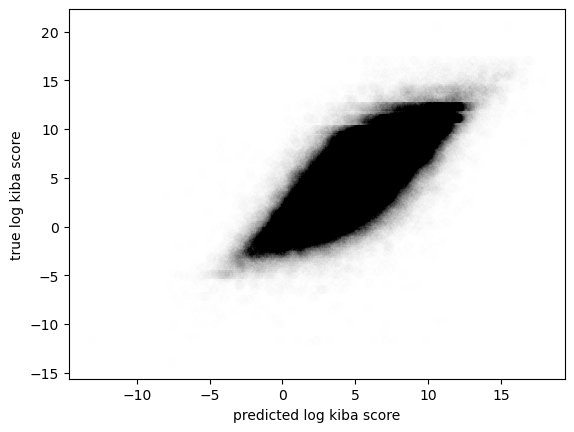

In [95]:
plt.plot(y_pred, y_test, 'ok', alpha=0.005)
plt.xlabel('predicted log kiba score')
plt.ylabel('true log kiba score')
plt.show()

In [96]:
import seaborn as sns

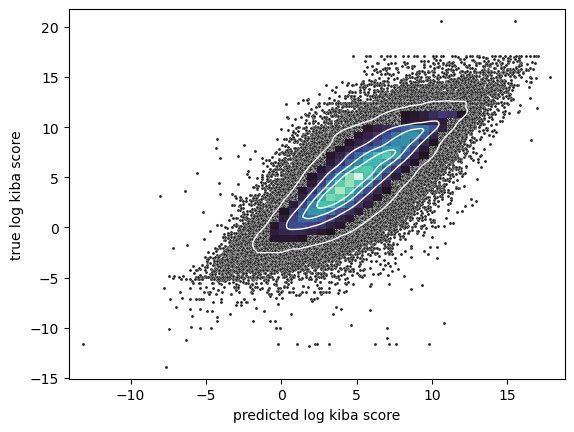

In [106]:
sns.scatterplot(x=y_pred, y=y_test, s=5, color=".15")
sns.histplot(x=y_pred, y=y_test, bins=50, pthresh=.1, cmap="mako")
sns.kdeplot(x=y_pred, y=y_test, levels=5, color="w", linewidths=1)
plt.xlabel('predicted log kiba score')
plt.ylabel('true log kiba score')
plt.show()

## 5.1 feature importances

In [100]:
reg_importances = reg.feature_importances_

In [101]:
reg_importance_order = np.argsort(reg_importances)

In [108]:
X.columns[reg_importance_order][-5:]

Index(['protein_seq_gravy', 'HeavyAtomCount', 'PatentFamilyCount',
       'extraAttributes.countByFeatureType.DNA binding', 'MonoisotopicMass'],
      dtype='object')

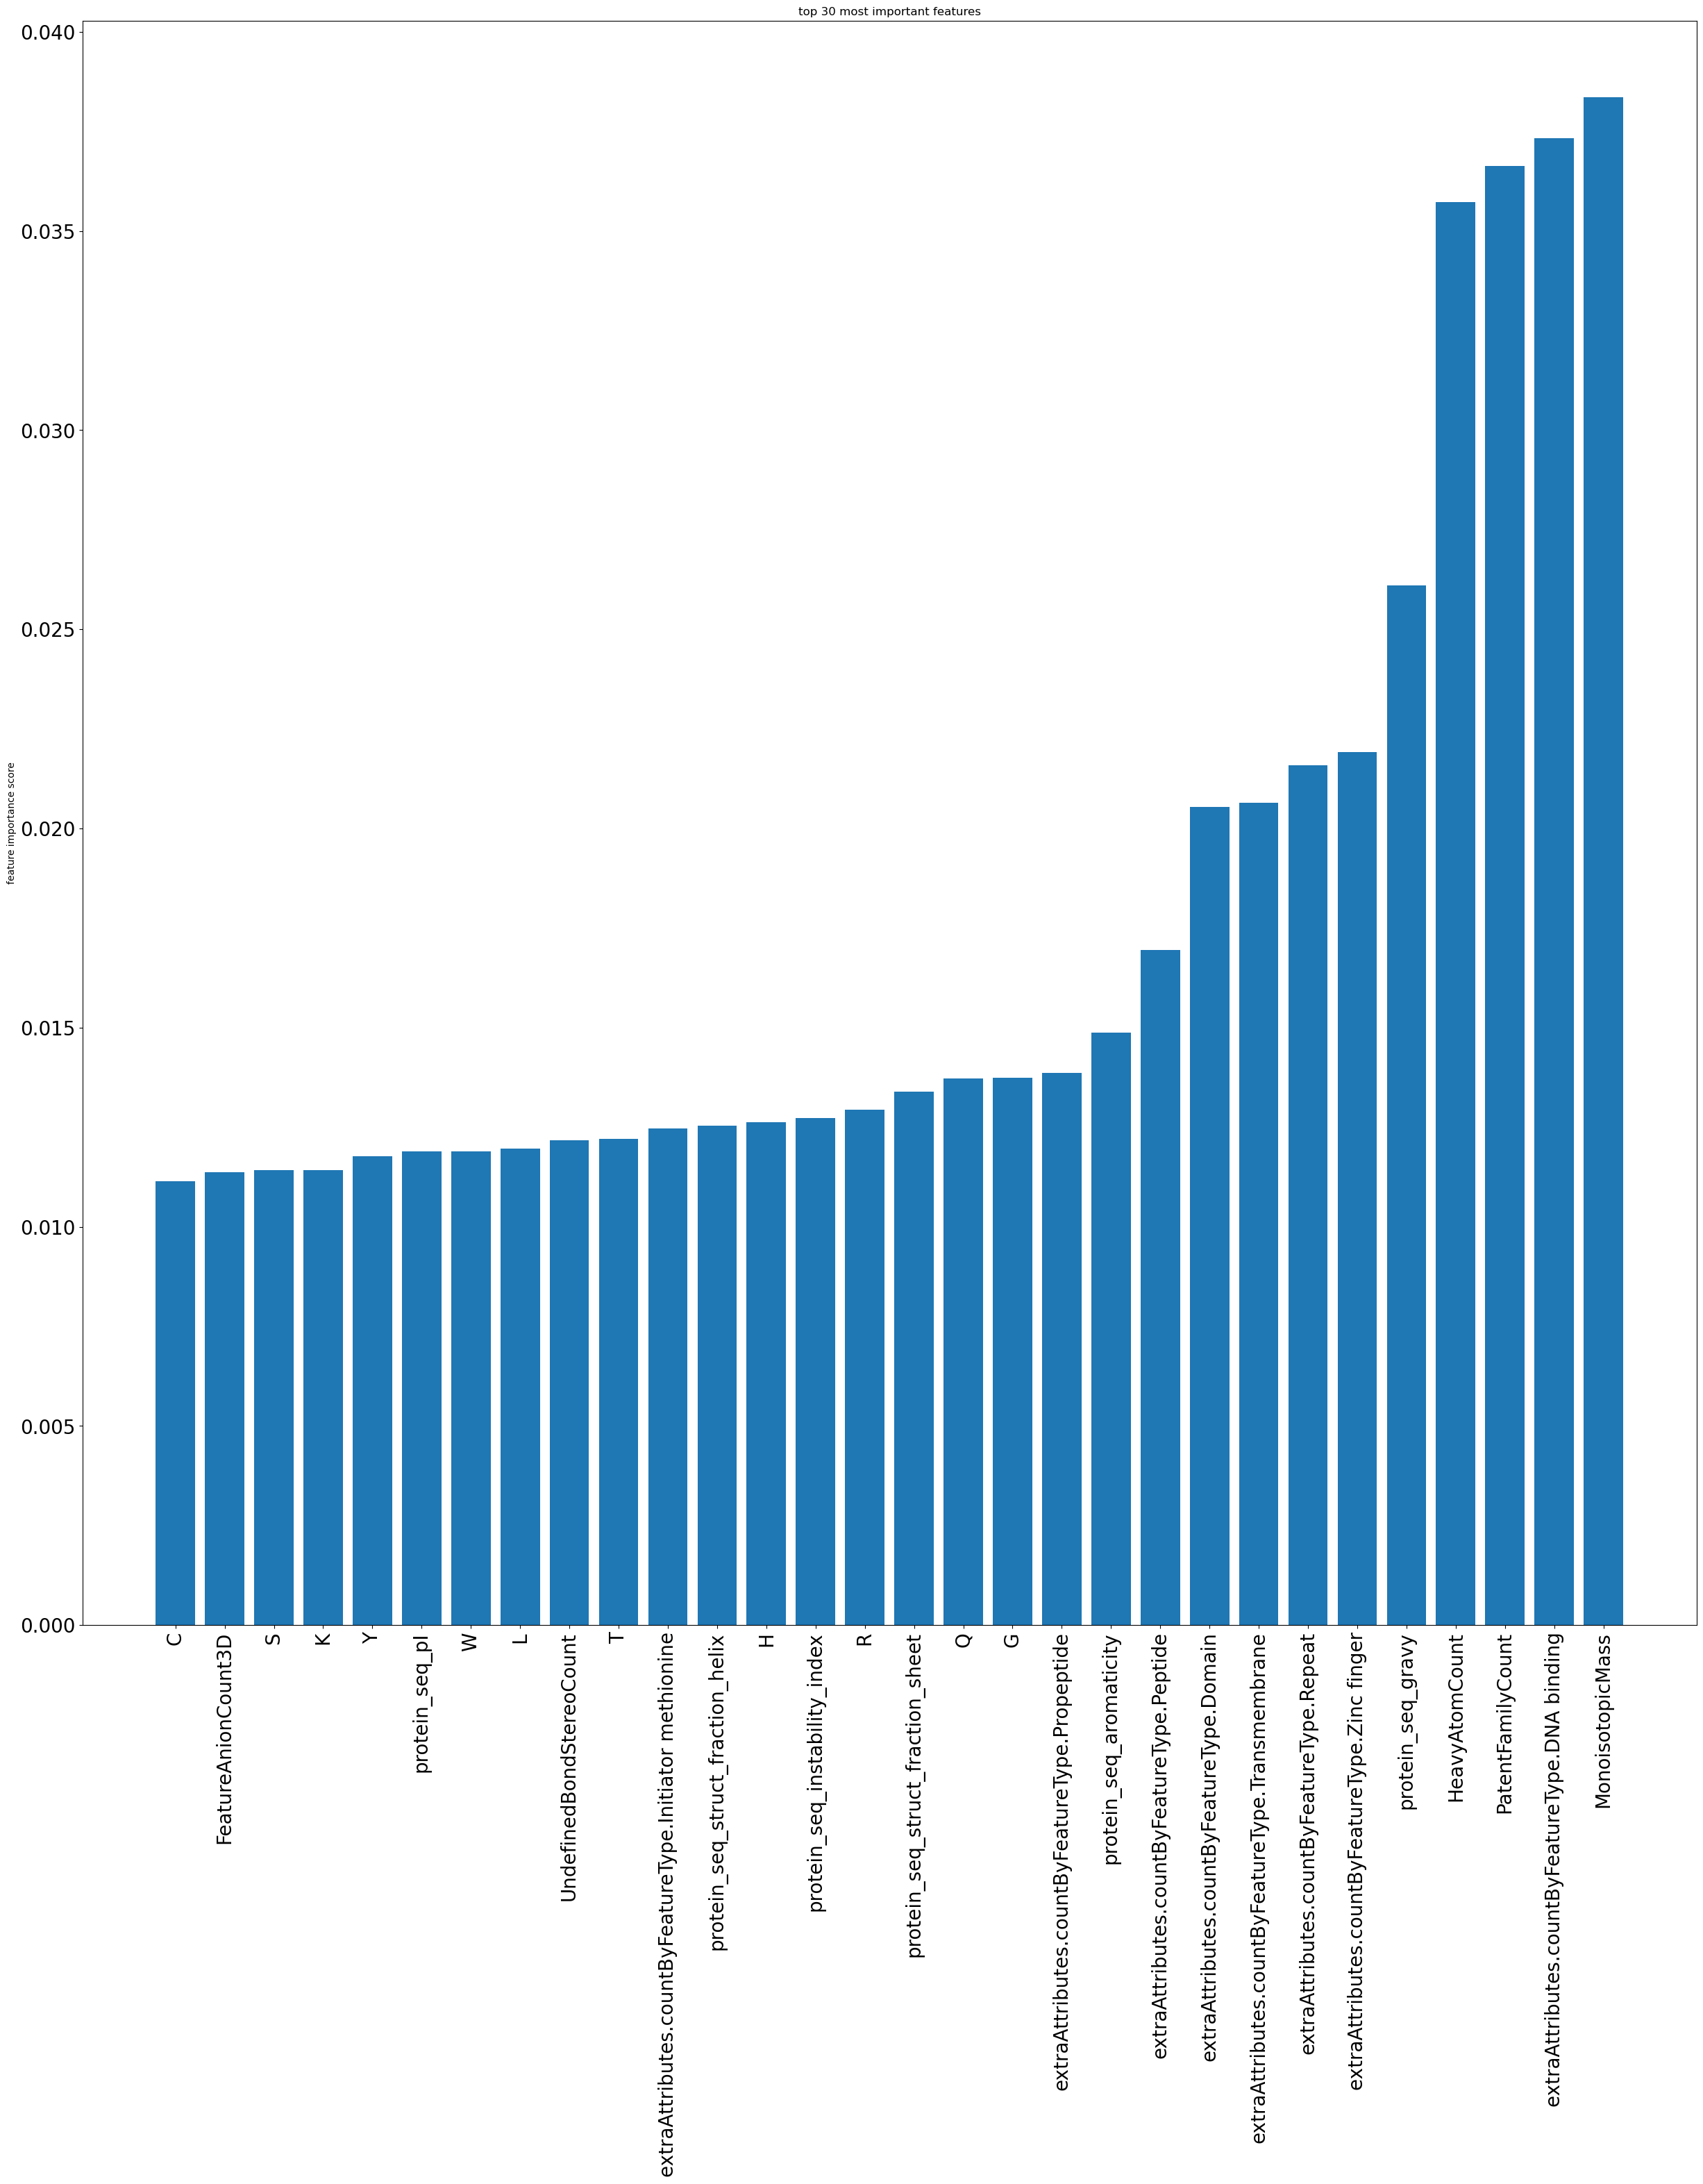

In [105]:
plt.figure(figsize =(30,30))
plt.bar(X.columns[reg_importance_order][-30:], reg_importances[reg_importance_order][-30:])
plt.xticks(rotation=90, fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('feature importance score')
plt.title('top 30 most important features')
plt.show()

In other iterations, I've seen other features become more important.. so i'm not totally sold that these are truly the most predictive features, but it is interesting to see a mix of chemical features, protein features, and protein sequence features! 

In [107]:
reg.save_model('best_fit_xgb_reg_model.json')
